In [1]:
# Hyperparameters
seq_length = 30 #window
batch_size = 16
input_size = seq_length  # Input size is the sequence length
hidden_size = 10  # Number of neurons in the hidden layers
output_size = seq_length  # Output size is the sequence length
learning_rate = 0.00001
num_epochs = 200

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import maketab as mt

In [3]:
def normalize(train_data):
    mins = np.min(train_data, axis=1, keepdims=True)
    maxs = np.max(train_data, axis=1, keepdims=True)
    normalized_train = (train_data - mins) / (maxs - mins)
    params = {'mins': mins, 'maxs': maxs}   
    return normalized_train, params

def denormalize(normalized_train, params):
    mins = params['mins']
    maxs = params['maxs']
    denormalized_train = normalized_train * (maxs - mins) + mins    
    return denormalized_train

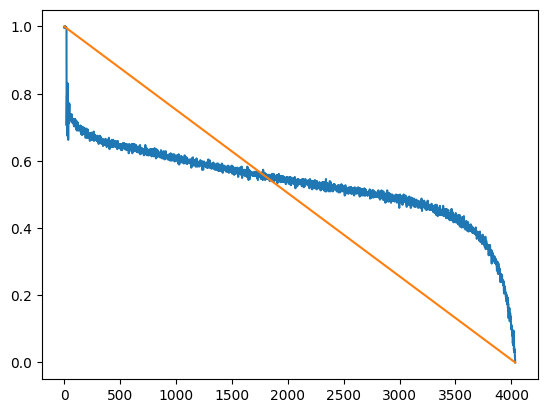

In [19]:
"""
def load_data(path_dir):
    t = mt.time(path_dir)
    tleft = 1 - t / max(t)
    motor = mt.readcsv(path_dir+'motor.csv')
    motor = (motor/65535)*100
    thr = mt.thrust(path_dir)
    av = mt.ang_vel(path_dir)
    #me = thr*0.05*av*0.1
    me = ((thr[1]/4)*av[1] + (thr[2]/4)*av[2] + (thr[3]/4)*av[3] + (thr[4]/4)*av[4])*0.047*0.1*0.05
    return me, tleft, t
"""
#"""
def load_data(path_dir):
    t, signal = mt.battery(path_dir)
    tleft = 1 - t / max(t)
    return signal, tleft, t
#"""

train_data = load_data('data/5-2-25/')
test_data = load_data('data/4-2-25/')
train_data, train_param = normalize(train_data)
test_data, test_param = normalize(test_data)

In [5]:
def prepare_data(data, seq_length):
    input_data = data[0]
    output_data = data[1]
    xs, ys = [], []
    for i in range(len(input_data) - seq_length):
        x = input_data[i:i + seq_length]  # Input sequence (noisy nonlinear)
        y = output_data[i:i + seq_length]  # Output sequence (linear)
        xs.append(x)
        ys.append(y)
    xs = np.array(xs)
    ys = np.array(ys)
    X_train = torch.tensor(xs, dtype=torch.float32)  # Shape: (batch_size, seq_length)
    y_train = torch.tensor(ys, dtype=torch.float32)  # Shape: (batch_size, seq_length)
    return X_train, y_train

X_train, y_train = prepare_data(train_data, seq_length)
X_test, y_test = prepare_data(test_data, seq_length)

# Create training DataLoader for batching
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print(X_train.shape, y_train.shape)

torch.Size([4005, 30]) torch.Size([4005, 30])


In [6]:
#'''
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Input to hidden layer
        self.fc2 = nn.Linear(hidden_size, output_size)  # Hidden to output layer
        self.relu = nn.ReLU()  # Activation function
        self.prelu = nn.PReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        out = self.fc1(x)  # Pass through the hidden layer
        #out = self.relu(out)  # Apply ReLU activation
        out = self.tanh(out)
        out = self.fc2(out)  # Pass through the output layer
        return out
#'''

In [7]:
# Initialize the model, loss function, and optimizer
model = MLP(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
# Training loop
def train(dataloader):
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_X)  # Shape: (batch_size, seq_length)
            loss = criterion(outputs, batch_y)  # Ensure shapes match
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
    
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(dataloader):.4f}')

train(dataloader)

Epoch [10/200], Loss: 0.1790
Epoch [20/200], Loss: 0.1011
Epoch [30/200], Loss: 0.0678
Epoch [40/200], Loss: 0.0543
Epoch [50/200], Loss: 0.0483
Epoch [60/200], Loss: 0.0450
Epoch [70/200], Loss: 0.0425
Epoch [80/200], Loss: 0.0402
Epoch [90/200], Loss: 0.0380
Epoch [100/200], Loss: 0.0358
Epoch [110/200], Loss: 0.0337
Epoch [120/200], Loss: 0.0316
Epoch [130/200], Loss: 0.0296
Epoch [140/200], Loss: 0.0276
Epoch [150/200], Loss: 0.0258
Epoch [160/200], Loss: 0.0240
Epoch [170/200], Loss: 0.0224
Epoch [180/200], Loss: 0.0210
Epoch [190/200], Loss: 0.0196
Epoch [200/200], Loss: 0.0185


(4035,)
[0.00000000e+00 2.47892910e-04 4.95785821e-04 ... 9.99504214e-01
 9.99752107e-01 1.00000000e+00]


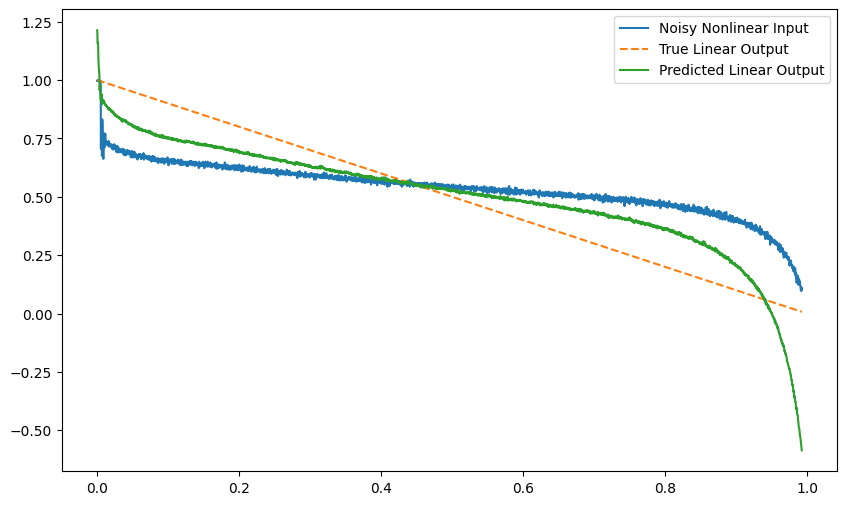

(3899,)
[0.00000000e+00 2.56541816e-04 5.13083633e-04 ... 9.99486916e-01
 9.99743458e-01 1.00000000e+00]


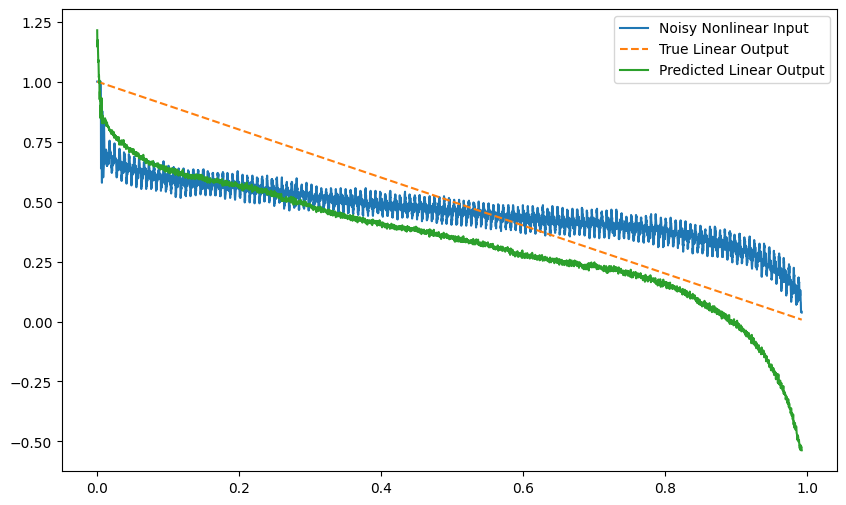

In [22]:
# Test the model
def test(X, data):
    model.eval()
    with torch.no_grad():
        predicted = model(X).numpy()  # Shape: (batch_size, seq_length)
    
    # Plot results
    t = np.linspace(0, 1, len(data[0]))
    print(t.shape)
    print(t)
    plt.figure(figsize=(10, 6))
    plt.plot(t[:len(predicted)], data[0][:len(predicted)], label='Noisy Nonlinear Input')
    plt.plot(t[:len(predicted)], data[1][:len(predicted)], label='True Linear Output', linestyle='--')
    #plt.plot(t[:len(predicted)], predicted.mean(axis=1), label='Predicted Linear Output')  # Mean across batch
    plt.plot(t[:len(predicted)], predicted[:, 0], label='Predicted Linear Output')  # Mean across batch
    #plt.scatter(t[:len(predicted)], predicted.mean(), label='Predicted Linear Output')  # Mean across batch
    plt.legend()
    plt.show()

test(X_train, train_data)
test(X_test, test_data)

In [ ]:
#slope2, slope, intercept, mean, std

def eval(data):
    model.eval()
    with torch.no_grad():
        
        input_data = data[0]
        output_data = data[1]
        time_data = np.arange(len(input_data))
        for i in range(starting_point, len(input_data) - seq_length, seq_length):
            x = input_data[i:i + seq_length]
            t = time_data[i:i + seq_length]
            print(t)
            y = output_data[i:i + seq_length]
            #print(f"x data: {x}")
            #print(f"t data: {t}")

            slope2, slope, intercept = np.polyfit(t, x, 2)
            mean = np.mean(x)
            std = np.std(x)
            #slope = slope*10**(5)
            #slope2 = slope2*10**(8)
            #std = std*10**(1)
            X = torch.tensor((slope2, slope, intercept, mean, std), dtype=torch.float32)
            #print(f"X = {X}")
            pred = model(X).numpy()
            #reg = 10**(-8)*pred[0]*t**2 + 10**(-5)*pred[1]*t + pred[2] #Unscaling the numbers back
            reg = pred[0]*t**2 + pred[1]*t + pred[2] #Unscaling the numbers back
            print(f"result: {reg[0]}")
            
            plt.plot(t, x, c='blue', label="baterie[V]")
            plt.plot(t, y, c='red', label="realna odhadovana kapacita[%]")
            plt.plot(t, reg, c='green', label="predikovana kapacita [%]")
            if (i <= starting_point): #otherwise it will print more than once
                plt.legend()
            #plt.errorbar(t[0], pred[3], pred[4], linestyle='None')
            #plt.scatter(t[0], pred[3], color="black", linewidth=1)

        #plt.show()

print("Trenovaci")
eval(train_data)
#plt.savefig("pow_train.png")
#plt.show()
print("Testovaci")
eval(test_data)
#plt.savefig("pow_test.png")
#plt.show()